In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
import batman
from scipy.optimize import minimize
from scipy.signal import find_peaks
# Disclaimer: Most of this is unoriginal and ripped directly from a random online tutorial.

In [33]:
data_planet = pd.read_excel("ep206103150.xlsx")

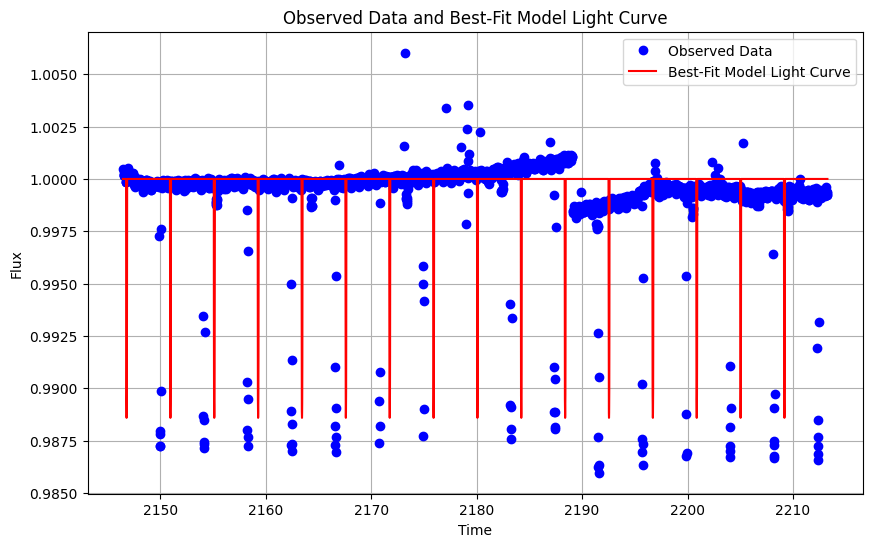

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import batman

# Load data (provide the path to your dataset)
data_planet = pd.read_excel("ep206103150.xlsx")
time_data = np.array(data_planet['time'])
flux_data = np.array(data_planet['flux'])

# Define a function to generate the model light curve with best-fit parameters
def generate_model(time, params):
    m = batman.TransitModel(params, time)
    return m.light_curve(params)

# Best-fit parameters for WASP-47b from the papers
initial_params = batman.TransitParams()
initial_params.t0 = 2150.96
initial_params.per = 4.1591
initial_params.rp = 0.10186
initial_params.a = 13.18
initial_params.inc = 87.47
initial_params.ecc = 0.0
initial_params.w = 90.0

# Generate the model light curve with best-fit parameters
model_time = np.linspace(time_data.min(), time_data.max(), len(time_data) * 10)
model_flux = generate_model(model_time, best_fit_params)

# Plot the observed data without connecting the blue points
plt.figure(figsize=(10, 6))
plt.plot(time_data, flux_data, marker='o', linestyle='', color='b', label='Observed Data')

# Plot the model with a higher density of points
plt.plot(model_time, model_flux, color='r', label='Best-Fit Model Light Curve')

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Observed Data and Best-Fit Model Light Curve')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
import batman
from scipy.optimize import minimize
from scipy.signal import find_peaks

# Load data (provide the path to your dataset)
data_planet = pd.read_excel("ep206103150.xlsx")
time_data = np.array(data_planet['time'])
flux_data = np.array(data_planet['flux'])

# Function to detect the first dip in the data
def find_first_dip(flux, prominence=0.01):
    peaks, _ = find_peaks(-flux, prominence=prominence)
    if peaks.any():
        return peaks[0]
    return None

# Define a function to fit transit parameters and generate the model light curve
def fit_transit_parameters(time, flux, initial_params):
    # Detect the first dip
    first_dip_index = find_first_dip(flux)

    if first_dip_index is not None:
        # Use the first dip as the initial transit center time
        tempt0 = time[first_dip_index]

    # Generate a finer time grid during transit for a smoother model
    time_fine = np.linspace(time[0], time[-1], len(time) * 10)

    # Define the transit model parameters
    params = batman.TransitParams()
    params.t0 = tempt0
    params.per = initial_params.per
    params.rp = initial_params.rp
    params.a = (params.per**2)**(1/3)
    params.inc = initial_params.inc
    params.ecc = initial_params.ecc
    params.w = initial_params.w
    params.limb_dark = "nonlinear"
    params.u = [0.5, 0.1, 0.1, -0.1]
  

    # Initialize the BATMAN transit model
    m = batman.TransitModel(params, time_fine)

    # Define a function to minimize, which calculates the residuals
    def objective(p):
        # Update parameters
        params.t0, params.rp, params.per, params.a = p

        # Initialize the BATMAN transit model with updated parameters
        m = batman.TransitModel(params, time)

        # Calculate the model light curve
        flux_model = m.light_curve(params)

        # Calculate residuals
        residuals = flux - flux_model

        # Return the sum of squared residuals
        return np.sum(residuals**2)

    # Perform the optimization to find best-fit parameters (t0, rp, per, a, u1, u2)
    initial_guess = [params.t0, params.rp, params.per, params.a,]
    bounds = [(params.t0 - 5, params.t0 + 5),  # Adjusting bounds for better exploration
              (params.rp * 0.5, params.rp * 2.0),
              (params.per * 0.8, params.per * 1.2),
              (params.a * 0.8, params.a * 1.2)]

    result = minimize(objective, initial_guess, method='Nelder-Mead', bounds=bounds)

    # Get the best-fit parameters
    best_fit_params = result.x
    params.t0, params.rp, params.per, params.a = best_fit_params

    #print("Final parameters:")
    #print("t0:", params.t0)
    #print("rp:", params.rp)
    #print("per:", params.per)
    #print("a:", params.a)
    #print(result)

    # Initialize the BATMAN transit model with best-fit parameters
    m = batman.TransitModel(params, time)

    # Calculate the model light curve
    flux_model = m.light_curve(params)

    return flux_model, best_fit_params

# Function to generate the model light curve with given parameters
def generate_model(time, params):
    m = batman.TransitModel(params, time)
    return m.light_curve(params)

flux_model, temp_best_fit_params = fit_transit_parameters(time_data, flux_data, initial_params)
# Generate the model light curve with best-fit parameters. 2.07955 is the period divided by 2


model_time = np.linspace(best_fit_params.t0 - 2.07955, best_fit_params.t0 + 2.07955, len(time_data) * 10)
model_flux = generate_model(model_time, best_fit_params)

# Phase-fold the model
model_phase = ((model_time - best_fit_params.t0 + 0.5 * best_fit_params.per) % best_fit_params.per) - 0.5 * best_fit_params.per

# Phase-fold the data
orbital_phase = ((time_data - best_fit_params.t0 + 0.5 * best_fit_params.per) % best_fit_params.per) - 0.5 * best_fit_params.per

# Plot the observed data without connecting the blue points
plt.figure(figsize=(10, 6))
plt.plot(orbital_phase, flux_data, marker='o', linestyle='', color='b', label='Observed Data')

# Plot the model with a continuous line (higher density of points)
plt.plot(model_phase, model_flux, color='r', label='Best-Fit Model Light Curve', alpha=0.5)

plt.xlabel('Orbital Phase')
plt.ylabel('Flux')
plt.title("Phase-Folded Transit Curve")
plt.legend() 
plt.grid(True)
plt.show()

Final parameters:
t0: 2150.0329513685783
rp: 0.05910028349633073
per: 4.152274393212229
a: 3.1034695436350086
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.008013367041637907
             x: [ 2.150e+03  5.910e-02  4.152e+00  3.103e+00]
           nit: 154
          nfev: 270
 final_simplex: (array([[ 2.150e+03,  5.910e-02,  4.152e+00,  3.103e+00],
                       [ 2.150e+03,  5.910e-02,  4.152e+00,  3.103e+00],
                       ...,
                       [ 2.150e+03,  5.911e-02,  4.152e+00,  3.103e+00],
                       [ 2.150e+03,  5.909e-02,  4.152e+00,  3.103e+00]]), array([ 8.013e-03,  8.013e-03,  8.013e-03,  8.013e-03,
                        8.013e-03]))


AttributeError: 'numpy.ndarray' object has no attribute 't0'

In [46]:
#orbital_phase = ((time_data - best_fit_params.t0)) # * best_fit_params.per) % best_fit_params.per) - 0.5 * best_fit_params.per
#plt.plot(orbital_phase, flux_data)
#print(best_fit_params.t0)
#print(time_data)
print(best_fit_params)

[2.15003295e+03 5.91002835e-02 4.15227439e+00 3.10346954e+00]
